In [21]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

In [23]:
stevilo_razredov = 5
visina_slike, sirina_slike = 600, 600
velikost_slike = (visina_slike, sirina_slike)
potDatoteke = pathlib.Path('./../GeneriranjeSlik/slike_generirane/data')
print('Število vseh slik v mapah: ' + str(len(list(potDatoteke.glob('*/*.png')))))

Število vseh slik v mapah: 500


Resize images to 600x600 for EfficientNetB7

In [22]:
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/data"):
  for filename in filenames:
    if filename.endswith(".png"):
      im = Image.open(os.path.join(dirpath, filename))
      if im.size != velikost_slike:
        im = im.resize(velikost_slike)
        im.save(os.path.join(dirpath, filename))

[100, 100, 100, 100, 100]


[Text(0, 0, 'razred1'),
 Text(1, 0, 'razred2'),
 Text(2, 0, 'razred3'),
 Text(3, 0, 'razred4'),
 Text(4, 0, 'razred5')]

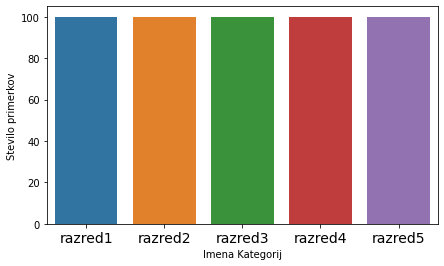

In [16]:
#štetje slik
PticaRibaMacka = [] #ustvari/sprazni array

# Naslednji del kode prešteje število slik v mapah (število mora bit identično za učenje!!)
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/data"):
    stevilo = len(filenames)
    if (stevilo != 0 and stevilo != 1):
      PticaRibaMacka.append(stevilo)

# Naslednji del kode prešteje število testnih slik v mapi ".../test"
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/test"):
    stevilo = len(filenames)
    if stevilo != 1 and stevilo != 0:
        PticaRibaMacka.append(stevilo)

# Ta del kode pridobi imena kategorij iz imen map
imena_kategorij = [] #ustvari/sprazni array
for root, dirs, files in os.walk("./../GeneriranjeSlik/slike_generirane/data", topdown=False):
    for name in dirs:
        imena_kategorij.append(os.path.join(name))

print(PticaRibaMacka)          
# imena_kategorij.append("testna")
#izris grafa
fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)

#Ustvarjanje dataframea (iz slovarja) za stolpični graf
slovar = pd.DataFrame.from_dict({"Imena Kategorij":imena_kategorij, "Stevilo primerkov":PticaRibaMacka})
bar = sns.barplot(data = slovar, x = "Imena Kategorij", y = "Stevilo primerkov", ax=ax)

bar.set_xticklabels(bar.get_xmajorticklabels(), fontsize = 14)

In [17]:
#Velikost serije batch
velikost_serije = 32

ucna_mnozica = tf.keras.preprocessing.image_dataset_from_directory(
    potDatoteke,
    validation_split=0.2,
    label_mode="int",
    subset="training",
    seed=1337,
    image_size=(velikost_slike),
    batch_size=velikost_serije,
)

#print(ucna_mnozica)
testna_mnozica = tf.keras.preprocessing.image_dataset_from_directory(
    potDatoteke,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(velikost_slike),
    batch_size=velikost_serije,
)
imena_razredov = testna_mnozica.class_names

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


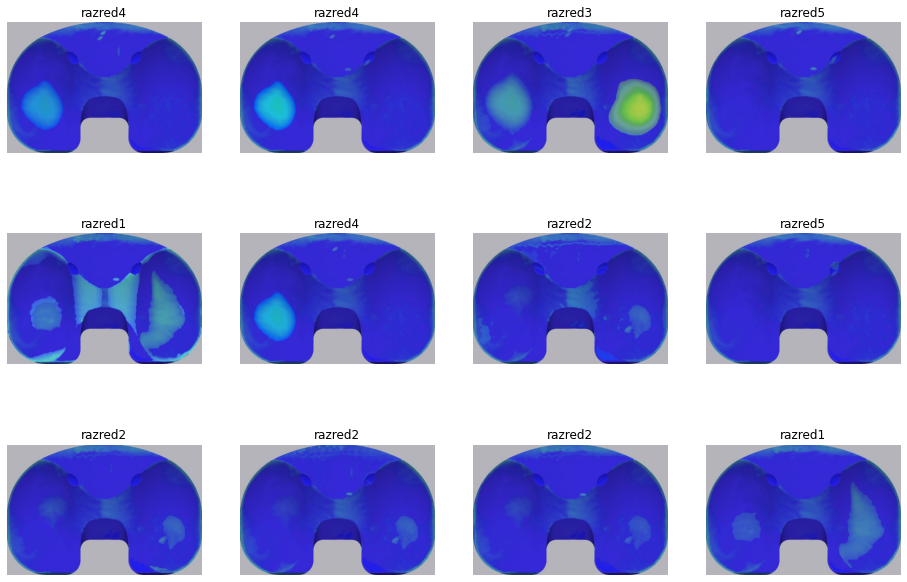

In [20]:
plt.figure(figsize=(16, 11))
for images, labels in ucna_mnozica.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(imena_razredov[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('vertical', input_shape=(visina_slike, sirina_slike, 3)),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.3),
    ]
)